In [1]:
import copy
import lmfit
import numpy as np
import matplotlib.pyplot as plt
from rich.progress import Progress
from scipy.stats import binned_statistic
from utils.plot_utils import set_fontsize
from utils.hdf_utils import load_measurement_data_devices_attrs

In [4]:
fname = "2021_2_26.hdf"
dset_name = "1614374968 find Q4 absorption"
devices = ()

In [5]:
yag_channel = 0
pmt_channel = 1
pd_channel = 2
pdn_channel = 3

freq_attr = 'Laser Lock 2 SetLockPointSeed3'

In [6]:
pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(fname, dset_name, devices)

freq_data = np.array([pxie_attrs[idx][freq_attr] for idx in range(1,len(pxie)+1)])

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
norm_data = -pd_data/pdn_data

In [7]:
dset_len = 2000
nbunch = 5

In [8]:
mask_yag = yag_data.max(axis = 1) < 500
mask_absorption = norm_data.max(axis = 1) > 0
pmt_data[mask_yag | mask_absorption] = np.nan
norm_data[mask_yag | mask_absorption] = np.nan

pmt_data_avg = np.nanmean(pmt_data.reshape(-1,nbunch,dset_len), axis = 1)
norm_data_avg = np.nanmean(norm_data.reshape(-1,nbunch,dset_len), axis = 1)

pmt_data_avg -= pmt_data_avg[:,100:250].mean(axis = 1)[:,np.newaxis]
norm_data_avg -= norm_data_avg[:,-750:].mean(axis = 1)[:,np.newaxis]

freq_data_avg = freq_data.reshape(-1,nbunch).mean(axis = 1)

fluorescence_integral = np.trapz(pmt_data_avg[:,100:], axis = 1)
absorption_integral = np.trapz(norm_data_avg[:,10:1250], axis = 1)

<ipython-input-8-d509b60ee146>:6: RuntimeWarning: Mean of empty slice
  pmt_data_avg = np.nanmean(pmt_data.reshape(-1,nbunch,dset_len), axis = 1)
<ipython-input-8-d509b60ee146>:7: RuntimeWarning: Mean of empty slice
  norm_data_avg = np.nanmean(norm_data.reshape(-1,nbunch,dset_len), axis = 1)


Text(0.5, 0, 'integral [bits]')

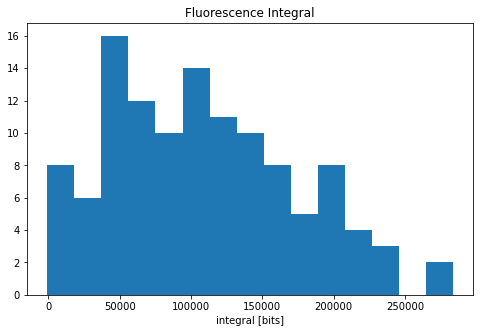

In [9]:
fig, ax = plt.subplots(figsize = (8,5))

ax.hist(fluorescence_integral, bins = 15)

ax.set_title('Fluorescence Integral')
ax.set_xlabel('integral [bits]')

In [10]:
mask_fluorescence = fluorescence_integral <= 5e4

fluorescence_integral[mask_fluorescence] = np.nan
absorption_integral[mask_fluorescence] = np.nan

<ipython-input-33-c7eb39a3cc90>:1: RuntimeWarning: Mean of empty slice
  bin_fun = lambda x: np.nanmean(x)


Text(0.5, 0, 'uv frequency [MHz]')

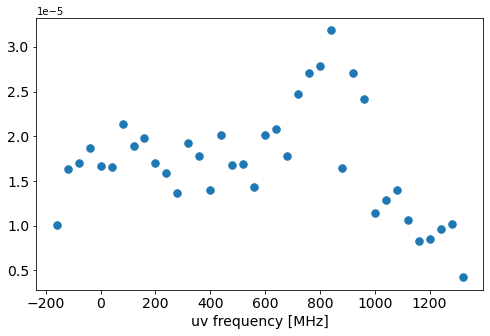

In [33]:
bin_fun = lambda x: np.nanmean(x)

bin_width = 5
bins = np.arange(freq_data.min()-bin_width/2, freq_data.max()+bin_width/2, bin_width)

stat, bin_edges, bin_number = binned_statistic(freq_data_avg, absorption_integral/fluorescence_integral, statistic = bin_fun, bins = bins)

bin_means = bin_edges[:-1]+np.diff(bin_edges)[0]/2

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(bin_means*4, stat, '.', ms = 15)
set_fontsize(ax, 14)

ax.set_xlabel('uv frequency [MHz]')

210.0 MHz IR


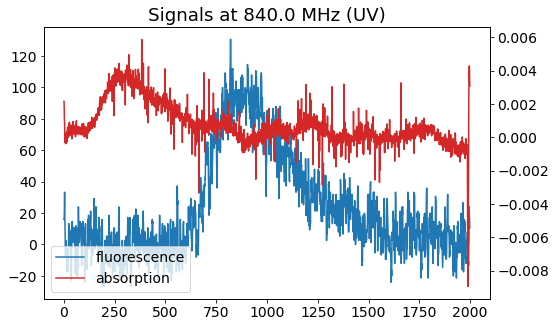

In [34]:
idx_max = np.where(np.nanargmax(stat)+1 == bin_number)[0][0]

fig, ax = plt.subplots(figsize = (8,5))

ax.plot(pmt_data_avg[idx_max], label = 'fluorescence')
ax1 = ax.twinx()
ax1.plot(norm_data_avg[idx_max], color = 'C3', label = 'absorption')

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax1.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, fontsize = 14)

# fig.legend(fontsize = 14, bbox_to_anchor = (0.9, 0.875))

ax.set_title(f'Signals at {freq_data_avg[idx_max]*4} MHz (UV)')
set_fontsize(ax, 14)
set_fontsize(ax1, 14)

print(f"{freq_data_avg[idx_max]} MHz IR")

# Correlation Q23 fluorescence and Q4 absorption

In [107]:
fname = "2021_2_26.hdf"
dset_name = "1614379530 correlation Q23 fluorescence and Q4 absorption"
devices = ()

In [108]:
yag_channel = 0
pmt_channel = 1
pd_channel = 2
pdn_channel = 3

In [109]:
pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(fname, dset_name, devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
norm_data = -pd_data/pdn_data

In [110]:
dset_len = 2000
nbunch = 5

mask_yag = yag_data.max(axis = 1) < 500
mask_laser_absorption = pdn_data.max(axis = 1) < 6000
mask_absorption = norm_data.max(axis = 1) > 0

mask = mask_yag | mask_laser_absorption | mask_absorption

pmt_data[mask] = np.nan
norm_data[mask] = np.nan

pmt_data_avg = np.nanmean(pmt_data.reshape(-1,nbunch,dset_len), axis = 1)
norm_data_avg = np.nanmean(norm_data.reshape(-1,nbunch,dset_len), axis = 1)

pmt_data_avg -= pmt_data_avg[:,100:250].mean(axis = 1)[:,np.newaxis]
norm_data_avg -= norm_data_avg[:,-750:].mean(axis = 1)[:,np.newaxis]

fluorescence_integral = np.trapz(pmt_data_avg[:,100:], axis = 1)
absorption_integral = np.trapz(norm_data_avg[:,10:1250], axis = 1)

<ipython-input-110-a751574f1ea3>:13: RuntimeWarning: Mean of empty slice
  pmt_data_avg = np.nanmean(pmt_data.reshape(-1,nbunch,dset_len), axis = 1)
<ipython-input-110-a751574f1ea3>:14: RuntimeWarning: Mean of empty slice
  norm_data_avg = np.nanmean(norm_data.reshape(-1,nbunch,dset_len), axis = 1)


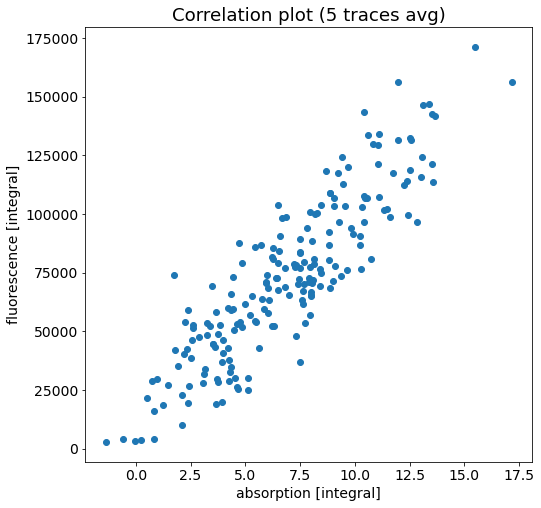

In [111]:
fig, ax = plt.subplots(figsize = (8,8))

ax.plot(absorption_integral, fluorescence_integral, '.', ms = 12)

ax.set_title(f"Correlation plot ({nbunch} traces avg)")
ax.set_xlabel("absorption [integral]")
ax.set_ylabel('fluorescence [integral]')
set_fontsize(ax, 14)

<ipython-input-112-efbc6f3b57b6>:1: RuntimeWarning: Mean of empty slice
  ab = norm_data - np.nanmean(norm_data[:,-750:], axis = 1)[:,np.newaxis]
<ipython-input-112-efbc6f3b57b6>:3: RuntimeWarning: Mean of empty slice
  pmt = pmt_data - np.nanmean(pmt_data[:,100:250], axis = 1)[:,np.newaxis]


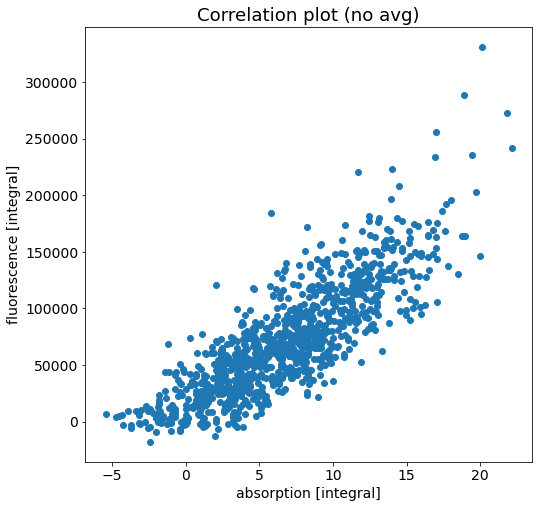

In [112]:
ab = norm_data - np.nanmean(norm_data[:,-750:], axis = 1)[:,np.newaxis]
ab = np.trapz(ab[:,10:1250], axis = 1)
pmt = pmt_data - np.nanmean(pmt_data[:,100:250], axis = 1)[:,np.newaxis]
pmt = np.trapz(pmt[:,100:], axis = 1)

fig, ax = plt.subplots(figsize = (8,8))

ax.plot(ab, pmt, '.', ms = 12)

ax.set_title(f"Correlation plot (no avg)")
ax.set_xlabel("absorption [integral]")
ax.set_ylabel('fluorescence [integral]')
set_fontsize(ax, 14)

# Scan R0 F1

In [138]:
fname = "2021_2_26.hdf"
dset_name = "1614380141 find R0 F1"
devices = ()

In [139]:
yag_channel = 0
pmt_channel = 1
pd_channel = 2
pdn_channel = 3

freq_attr = 'Laser Lock 1 SetLockPointSeed2'

In [140]:
pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(fname, dset_name, devices)

freq_data = np.array([pxie_attrs[idx][freq_attr] for idx in range(1,len(pxie)+1)])

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
norm_data = -pd_data/pdn_data

In [151]:
dset_len = 2000
nbunch = 5

mask_yag = yag_data.max(axis = 1) < 500
mask_laser_absorption = pdn_data.max(axis = 1) < 6000
mask_absorption = np.trapz(norm_data - norm_data[:,-750:].mean(axis = 1)[:,np.newaxis], axis = 1) < 2

mask = mask_yag | mask_laser_absorption | mask_absorption

pmt_data[mask] = np.nan
norm_data[mask] = np.nan

pmt_data_avg = np.nanmean(pmt_data.reshape(-1,nbunch,dset_len), axis = 1)
norm_data_avg = np.nanmean(norm_data.reshape(-1,nbunch,dset_len), axis = 1)

pmt_data_avg -= pmt_data_avg[:,100:250].mean(axis = 1)[:,np.newaxis]
norm_data_avg -= norm_data_avg[:,-750:].mean(axis = 1)[:,np.newaxis]

freq_data_avg = freq_data.reshape(-1,nbunch).mean(axis = 1)

fluorescence_integral = np.trapz(pmt_data_avg[:,100:], axis = 1)
absorption_integral = np.trapz(norm_data_avg[:,10:1250], axis = 1)

<ipython-input-151-ca285b67a4a2>:13: RuntimeWarning: Mean of empty slice
  pmt_data_avg = np.nanmean(pmt_data.reshape(-1,nbunch,dset_len), axis = 1)
<ipython-input-151-ca285b67a4a2>:14: RuntimeWarning: Mean of empty slice
  norm_data_avg = np.nanmean(norm_data.reshape(-1,nbunch,dset_len), axis = 1)


Text(0.5, 0, 'integral [bits]')

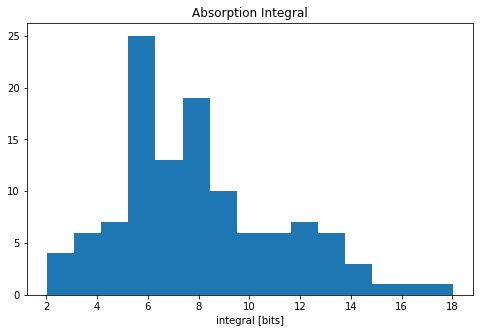

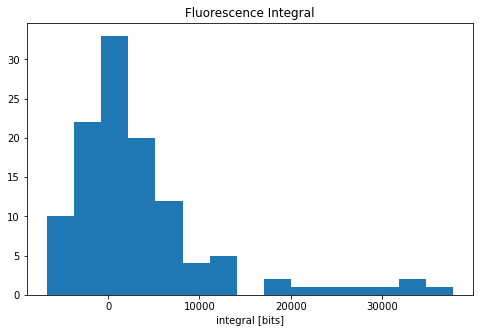

In [152]:
fig, ax = plt.subplots(figsize = (8,5))

ax.hist(absorption_integral, bins = 15)

ax.set_title('Absorption Integral')
ax.set_xlabel('integral [bits]')

fig, ax = plt.subplots(figsize = (8,5))

ax.hist(fluorescence_integral, bins = 15)

ax.set_title('Fluorescence Integral')
ax.set_xlabel('integral [bits]')

In [153]:
mask_absorption = absorption_integral <= 2

fluorescence_integral[mask_absorption] = np.nan
absorption_integral[mask_absorption] = np.nan

Text(0.5, 0, 'uv frequency [MHz]')

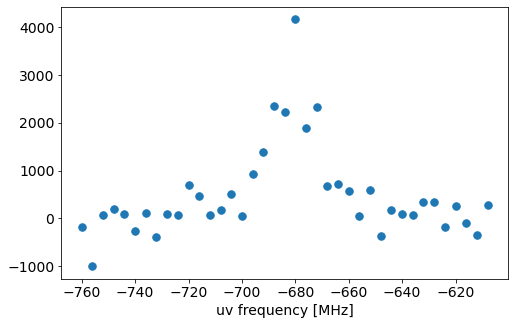

In [154]:
bin_fun = lambda x: np.nanmean(x)

bin_width = 1
bins = np.arange(freq_data.min()-bin_width/2, freq_data.max()+bin_width/2, bin_width)

stat, bin_edges, bin_number = binned_statistic(freq_data_avg, fluorescence_integral/absorption_integral, 
                                               statistic = bin_fun, bins = bins)

bin_means = bin_edges[:-1]+np.diff(bin_edges)[0]/2

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(bin_means*4, stat, '.', ms = 15)
set_fontsize(ax, 14)

ax.set_xlabel('uv frequency [MHz]')

3820.3700108697794
-170.0 MHz IR


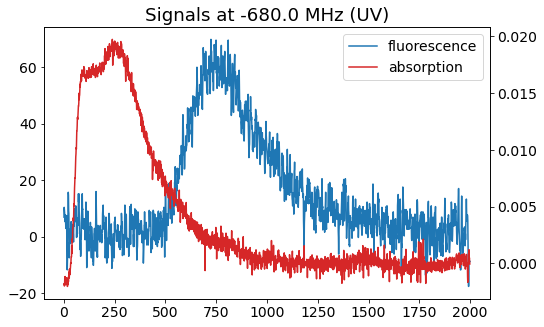

In [155]:
idx_max = np.where(np.nanargmax(stat)+1 == bin_number)[0]

pmt = np.nanmean(pmt_data_avg[idx_max], axis = 0)
ab  = np.nanmean(norm_data_avg[idx_max], axis = 0)

fig, ax = plt.subplots(figsize = (8,5))

ax.plot(pmt, label = 'fluorescence')
ax1 = ax.twinx()
ax1.plot(ab, color = 'C3', label = 'absorption')

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax1.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, fontsize = 14)

# fig.legend(fontsize = 14, bbox_to_anchor = (0.9, 0.875))

ax.set_title(f'Signals at {freq_data_avg[idx_max[0]]*4} MHz (UV)')
set_fontsize(ax, 14)
set_fontsize(ax1, 14)

print(np.nanmean(fluorescence_integral[idx_max], axis = 0)/np.nanmean(absorption_integral[idx_max], axis = 0))

print(f"{freq_data_avg[idx_max[0]]} MHz IR")

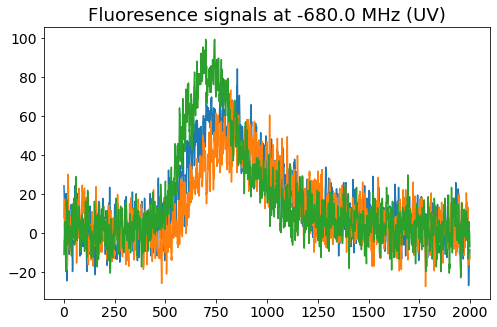

In [156]:
fig, ax = plt.subplots(figsize = (8,5))

ax.plot(pmt_data_avg[idx_max].T)

ax.set_title(f'Fluoresence signals at {freq_data_avg[idx_max[0]]*4} MHz (UV)')
set_fontsize(ax, 14)
set_fontsize(ax1, 14)

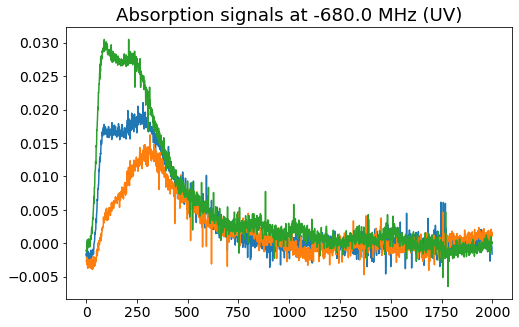

In [157]:
fig, ax = plt.subplots(figsize = (8,5))

ax.plot(norm_data_avg[idx_max].T)

ax.set_title(f'Absorption signals at {freq_data_avg[idx_max[0]]*4} MHz (UV)')
set_fontsize(ax, 14)
set_fontsize(ax1, 14)

# Correlation R0 F1 fluorescence and Q4 absorption

In [174]:
fname = "2021_2_26.hdf"
dset_name = "1614380911 correlation R0 F1 fluorescence and Q4 absorption"
devices = ()

In [175]:
yag_channel = 0
pmt_channel = 1
pd_channel = 2
pdn_channel = 3

In [176]:
pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(fname, dset_name, devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
norm_data = -pd_data/pdn_data

<ipython-input-176-abc7360e1df6>:7: RuntimeWarning: divide by zero encountered in true_divide
  norm_data = -pd_data/pdn_data


In [178]:
dset_len = 2000
nbunch = 5

mask_yag = yag_data.max(axis = 1) < 500
mask_laser_absorption = pdn_data.max(axis = 1) < 6000
mask_absorption = norm_data.max(axis = 1) > 0

mask = mask_yag | mask_laser_absorption | mask_absorption

pmt_data[mask] = np.nan
norm_data[mask] = np.nan


pmt_data_avg = np.nanmean(pmt_data.reshape(-1,nbunch,dset_len), axis = 1)
norm_data_avg = np.nanmean(norm_data.reshape(-1,nbunch,dset_len), axis = 1)

pmt_data_avg -= pmt_data_avg[:,100:250].mean(axis = 1)[:,np.newaxis]
norm_data_avg -= norm_data_avg[:,-750:].mean(axis = 1)[:,np.newaxis]

fluorescence_integral = np.trapz(pmt_data_avg[:,100:], axis = 1)
absorption_integral = np.trapz(norm_data_avg[:,10:1250], axis = 1)

<ipython-input-178-2971179686f6>:14: RuntimeWarning: Mean of empty slice
  pmt_data_avg = np.nanmean(pmt_data.reshape(-1,nbunch,dset_len), axis = 1)
<ipython-input-178-2971179686f6>:15: RuntimeWarning: Mean of empty slice
  norm_data_avg = np.nanmean(norm_data.reshape(-1,nbunch,dset_len), axis = 1)


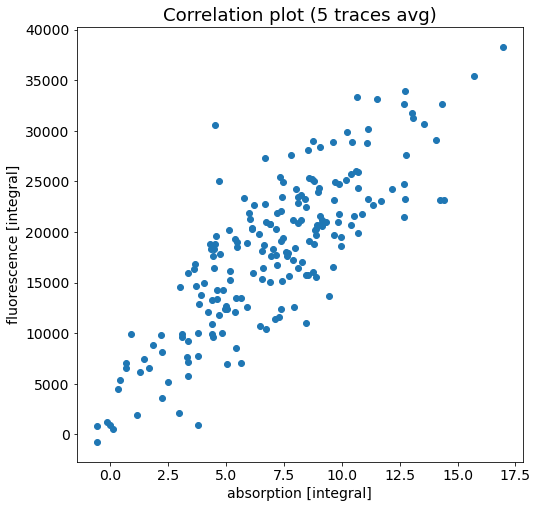

In [179]:
fig, ax = plt.subplots(figsize = (8,8))

ax.plot(absorption_integral, fluorescence_integral, '.', ms = 12)

ax.set_title(f"Correlation plot ({nbunch} traces avg)")
ax.set_xlabel("absorption [integral]")
ax.set_ylabel('fluorescence [integral]')
set_fontsize(ax, 14)

<ipython-input-180-efbc6f3b57b6>:1: RuntimeWarning: Mean of empty slice
  ab = norm_data - np.nanmean(norm_data[:,-750:], axis = 1)[:,np.newaxis]
<ipython-input-180-efbc6f3b57b6>:3: RuntimeWarning: Mean of empty slice
  pmt = pmt_data - np.nanmean(pmt_data[:,100:250], axis = 1)[:,np.newaxis]


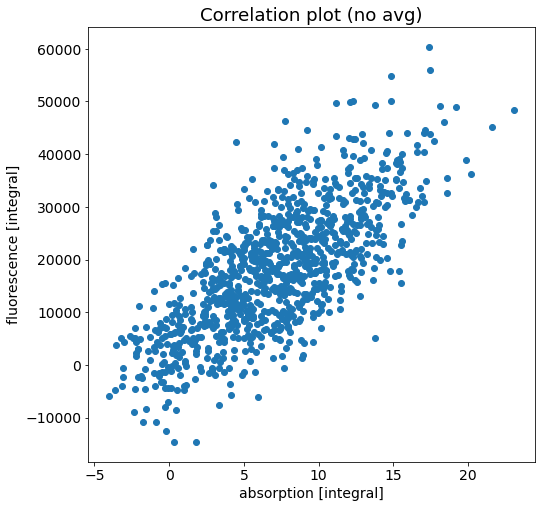

In [180]:
ab = norm_data - np.nanmean(norm_data[:,-750:], axis = 1)[:,np.newaxis]
ab = np.trapz(ab[:,10:1250], axis = 1)
pmt = pmt_data - np.nanmean(pmt_data[:,100:250], axis = 1)[:,np.newaxis]
pmt = np.trapz(pmt[:,100:], axis = 1)

fig, ax = plt.subplots(figsize = (8,8))

ax.plot(ab, pmt, '.', ms = 12)

ax.set_title(f"Correlation plot (no avg)")
ax.set_xlabel("absorption [integral]")
ax.set_ylabel('fluorescence [integral]')
set_fontsize(ax, 14)

## Check Different PMT Voltages without molecules

In [181]:
fname = "test.hdf"
dset_name = "1614383432 test"
devices = ()

In [184]:
yag_channel = 0
pmt_channel = 1
pd_channel = 2
pdn_channel = 3

volt_attr = 'PS350 SetVoltage'

In [187]:
pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(fname, dset_name, devices)

volt_data = np.array([pxie_attrs[idx][volt_attr] for idx in range(1,len(pxie)+1)])

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
norm_data = -pd_data/pdn_data

<ipython-input-187-6540ec7bec92>:9: RuntimeWarning: divide by zero encountered in true_divide
  norm_data = -pd_data/pdn_data


In [200]:
volt_data.max

array([-1025.,  -975.,  -925.,  -875.])

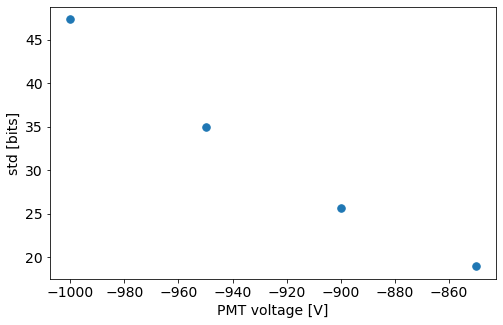

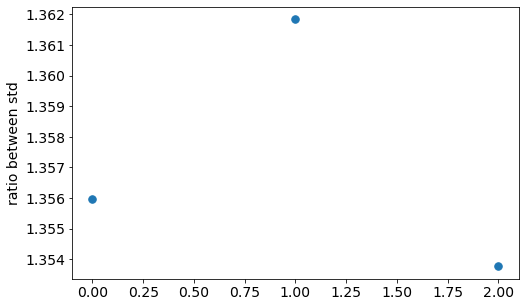

In [208]:
bin_fun = lambda x: np.mean(x)

bin_width = 50
bins = np.arange(volt_data.min()-bin_width/2, volt_data.max()+bin_width/2+bin_width, bin_width)

stat, bin_edges, bin_number = binned_statistic(volt_data, pmt_data.std(axis = 1), 
                                               statistic = bin_fun, bins = bins)

bin_means = bin_edges[:-1]+np.diff(bin_edges)[0]/2

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(bin_means, stat, '.', ms = 15)
set_fontsize(ax, 14)

ax.set_xlabel('PMT voltage [V]')
ax.set_ylabel('std [bits]');

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(stat[::-1][1:]/stat[::-1][:-1], '.', ms = 15)
set_fontsize(ax, 14)

ax.set_ylabel('ratio between std');

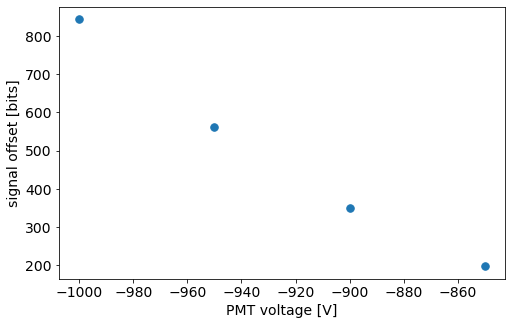

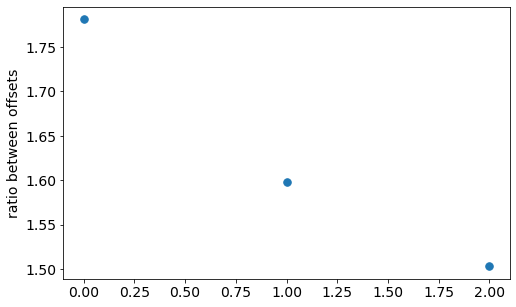

In [209]:
bin_fun = lambda x: np.mean(x)

bin_width = 50
bins = np.arange(volt_data.min()-bin_width/2, volt_data.max()+bin_width/2+bin_width, bin_width)

stat, bin_edges, bin_number = binned_statistic(volt_data, pmt_data.mean(axis = 1), 
                                               statistic = bin_fun, bins = bins)

bin_means = bin_edges[:-1]+np.diff(bin_edges)[0]/2

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(bin_means, stat, '.', ms = 15)
set_fontsize(ax, 14)

ax.set_xlabel('PMT voltage [V]')
ax.set_ylabel('signal offset [bits]');

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(stat[::-1][1:]/stat[::-1][:-1], '.', ms = 15)
set_fontsize(ax, 14)

ax.set_ylabel('ratio between offsets');